In [8]:
import os
import sys
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines  

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
config = load_json_config("config.json")

In [9]:
# import all sites with column "site" added
df_sites = []

# add datetime information
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [12,1,2]

for site in config["icos_cities_portal"]["site_names"]:

    df_site = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                            deployment_times=deployment_times,
                                            site_name=site) \
            .filter(pl.col("Flag") == "U") \
            .select(["datetime", "gmp343_corrected"]) \
            .with_columns(site = pl.lit(site)) \
            .with_columns(
            pl.col("datetime")
            .dt.convert_time_zone("Europe/Berlin")
            .alias("datetime_local")) \
            .with_columns(pl.col("datetime_local").dt.month().alias("month"),
                          pl.col("datetime_local").dt.hour().alias("hour_of_day")) \
            .with_columns(
                pl.when(pl.col("month").is_in(spring)).then(pl.lit("spring"))
                .when(pl.col("month").is_in(summer)).then(pl.lit("summer"))
                .when(pl.col("month").is_in(fall)).then(pl.lit("fall"))
                .when(pl.col("month").is_in(winter)).then(pl.lit("winter"))
                .otherwise(None)
                .alias("season")
            ).group_by(["site", "season", "hour_of_day"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("gmp343_corrected")) \
            .group_by(["site", "season"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("mean_co2"),
                pl.col("gmp343_corrected").median().alias("median_co2"),
                pl.col("gmp343_corrected").max().alias("max_co2"),
                pl.col("gmp343_corrected").min().alias("min_co2"),
                (pl.col("gmp343_corrected").max()- pl.col("gmp343_corrected").min()).alias("variation_co2"),
                pl.col("gmp343_corrected").std().alias("std_co2"),
                pl.col("gmp343_corrected").count().alias("count_co2"))
            
    df_sites.append(df_site)
    
df = pl.concat(df_sites)

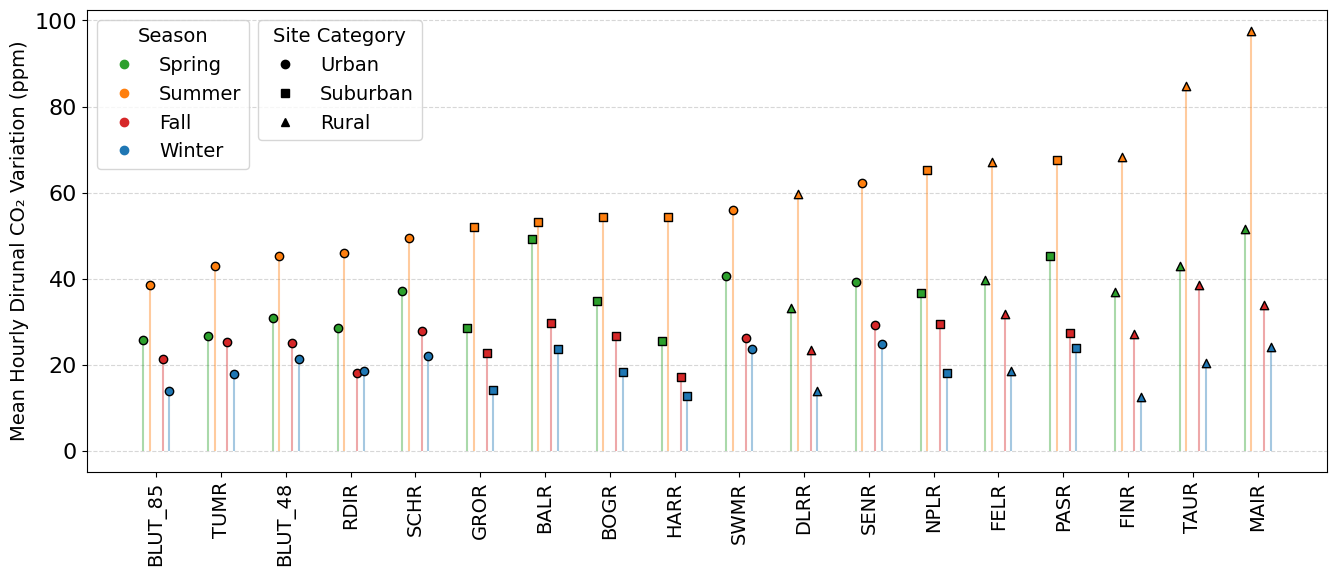

In [21]:
# Marker mapping
def get_marker(site):
    if site in config["site_classification"]["urban"]:
        return "o"  # Circle
    elif site in config["site_classification"]["rural"]:
        return "^"  # Triangle
    elif site in config["site_classification"]["suburban"]:
        return "s"  # Square fallback

# Define colors and offsets
season_order = ["spring", "summer", "fall", "winter"]

# Sort sites by summer mean_co2
sites_order = (
df.filter(pl.col("season") == "summer")
    .sort("variation_co2")
    .select("site")
    .to_series()
    .to_list()
)

season_colors = {
    "spring": "tab:green",
    "summer": "tab:orange",
    "fall":   "tab:red",
    "winter": "tab:blue"
}
offsets = {
    "spring": -0.2,
    "summer": -0.1,
    "fall":    0.1,
    "winter":  0.2
}

# Create site → index mapping
site_index_df = pl.DataFrame({
    "site": sites_order,
    "site_index": list(range(len(sites_order)))
})

# Join index into Polars DataFrame
df_plot = df.join(site_index_df, on="site", how="inner")

# Add offset column for x-position
offset_expr = (
    pl.when(pl.col("season") == "spring").then(offsets["spring"])
    .when(pl.col("season") == "summer").then(offsets["summer"])
    .when(pl.col("season") == "fall").then(offsets["fall"])
    .when(pl.col("season") == "winter").then(offsets["winter"])
    .otherwise(0.0)
)

df_plot = df_plot.with_columns(
    (pl.col("site_index") + offset_expr).alias("x_val")
)

# Prepare plot
x_pos = np.arange(len(sites_order))
plt.figure(figsize=(16, 6))

for season in season_order:
    subset = df_plot.filter(pl.col("season") == season)

    x_vals = subset["x_val"].to_numpy()
    y_vals = subset["variation_co2"].to_numpy()
    sites = config["icos_cities_portal"]["site_names"]

    # Draw vertical lines from x-axis to each point
    plt.vlines(
        x=x_vals,
        ymin=0,
        ymax=y_vals,
        color=season_colors[season],
        alpha=0.4,
        linewidth=1.5
    )

    # Plot the actual points
    for x, y, site in zip(x_vals, y_vals, sites):
        plt.scatter(
            x,
            y,
            label=season.capitalize(),
            color=season_colors[season],
            edgecolor="black",
            marker=get_marker(site),
            zorder=3,
        )
    
# Create legend handles for seasons
season_handles = [
    mlines.Line2D([], [], color=season_colors[s], marker="o", linestyle="None", label=s.capitalize())
    for s in season_order
]   

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Remove duplicate labels and keep the first occurrence
unique = {}
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h

leg1 = ax.legend(handles=season_handles, title="Season", loc="upper left", fontsize=14, title_fontsize=14)

# Create legend handles for site categories
marker_handles = [
    mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="Urban"),
        mlines.Line2D([], [], color="black", marker="s", linestyle="None", label="Suburban"),
    mlines.Line2D([], [], color="black", marker="^", linestyle="None", label="Rural"),
]
leg2 = ax.legend(handles=marker_handles, title="Site Category", loc="upper left", fontsize=14, title_fontsize=14, bbox_to_anchor=(0.13, 1))
ax.add_artist(leg1)
    
plt.xticks(
    ticks=np.arange(len(sites_order)),
    labels=sites_order,
    rotation=90,
    fontsize=14
)
plt.ylabel("Mean Hourly Dirunal CO₂ Variation (ppm)", fontsize=14)
ax.tick_params(axis='y', labelsize=16)  
#plt.title("Mean Hourly Dirunal CO₂ Variation by Site and Season")
plt.grid(axis="y", linestyle="--", alpha=0.5)
#plt.tight_layout()
plt.show()

In [4]:
# import all sites with column "site" added
df_sites = []

# add datetime information
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [12,1,2]

for site in config["icos_cities_portal"]["site_names"]:

    df_site = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                            deployment_times=deployment_times,
                                            site_name=site) \
            .filter(pl.col("Flag") == "U") \
            .select(["datetime", "gmp343_corrected"]) \
            .with_columns(site = pl.lit(site)) \
            .with_columns(
            pl.col("datetime")
            .dt.convert_time_zone("Europe/Berlin")
            .alias("datetime_local")) \
            .with_columns(pl.col("datetime_local").dt.month().alias("month"),
                          pl.col("datetime_local").dt.hour().alias("hour_of_day")) \
            .with_columns(
                pl.when(pl.col("month").is_in(spring)).then(pl.lit("spring"))
                .when(pl.col("month").is_in(summer)).then(pl.lit("summer"))
                .when(pl.col("month").is_in(fall)).then(pl.lit("fall"))
                .when(pl.col("month").is_in(winter)).then(pl.lit("winter"))
                .otherwise(None)
                .alias("season")) \
            .filter(pl.col("hour_of_day") >= 12) \
            .filter(pl.col("hour_of_day") <= 18) \
            .group_by(["site", "season", "hour_of_day"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("gmp343_corrected")) \
            .group_by(["site", "season"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("mean_co2"),
                pl.col("gmp343_corrected").median().alias("median_co2"),
                pl.col("gmp343_corrected").max().alias("max_co2"),
                pl.col("gmp343_corrected").min().alias("min_co2"),
                (pl.col("gmp343_corrected").max()- pl.col("gmp343_corrected").min()).alias("variation_co2"),
                pl.col("gmp343_corrected").std().alias("std_co2"),
                pl.col("gmp343_corrected").count().alias("count_co2"))
            
    df_sites.append(df_site)
    
df = pl.concat(df_sites)

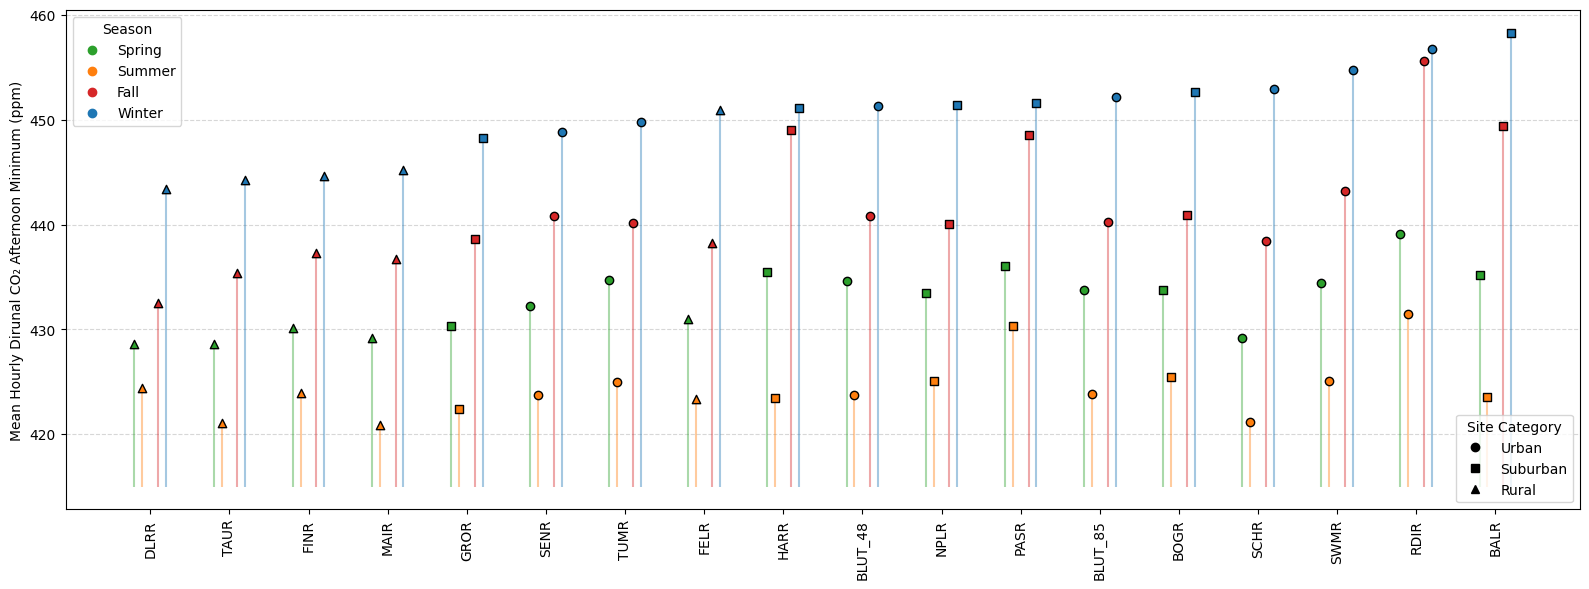

In [5]:
# Marker mapping
def get_marker(site):
    if site in config["site_classification"]["urban"]:
        return "o"  # Circle
    elif site in config["site_classification"]["rural"]:
        return "^"  # Triangle
    elif site in config["site_classification"]["suburban"]:
        return "s"  # Square fallback

# Define colors and offsets
season_order = ["spring", "summer", "fall", "winter"]

# Sort sites by summer mean_co2
sites_order = (
df.filter(pl.col("season") == "winter")
    .sort("min_co2")
    .select("site")
    .to_series()
    .to_list()
)

season_colors = {
    "spring": "tab:green",
    "summer": "tab:orange",
    "fall":   "tab:red",
    "winter": "tab:blue"
}
offsets = {
    "spring": -0.2,
    "summer": -0.1,
    "fall":    0.1,
    "winter":  0.2
}

# Create site → index mapping
site_index_df = pl.DataFrame({
    "site": sites_order,
    "site_index": list(range(len(sites_order)))
})

# Join index into Polars DataFrame
df_plot = df.join(site_index_df, on="site", how="inner")

# Add offset column for x-position
offset_expr = (
    pl.when(pl.col("season") == "spring").then(offsets["spring"])
    .when(pl.col("season") == "summer").then(offsets["summer"])
    .when(pl.col("season") == "fall").then(offsets["fall"])
    .when(pl.col("season") == "winter").then(offsets["winter"])
    .otherwise(0.0)
)

df_plot = df_plot.with_columns(
    (pl.col("site_index") + offset_expr).alias("x_val")
)

# Prepare plot
x_pos = np.arange(len(sites_order))
plt.figure(figsize=(16, 6))

for season in season_order:
    subset = df_plot.filter(pl.col("season") == season)

    x_vals = subset["x_val"].to_numpy()
    y_vals = subset["min_co2"].to_numpy()
    sites = config["icos_cities_portal"]["site_names"]

    # Draw vertical lines from x-axis to each point
    plt.vlines(
        x=x_vals,
        ymin=415,
        ymax=y_vals,
        color=season_colors[season],
        alpha=0.4,
        linewidth=1.5
    )

    # Plot the actual points
    for x, y, site in zip(x_vals, y_vals, sites):
        plt.scatter(
            x,
            y,
            label=season.capitalize(),
            color=season_colors[season],
            edgecolor="black",
            marker=get_marker(site),
            zorder=3,
        )
    
# Create legend handles for seasons
season_handles = [
    mlines.Line2D([], [], color=season_colors[s], marker="o", linestyle="None", label=s.capitalize())
    for s in season_order
]   

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Remove duplicate labels and keep the first occurrence
unique = {}
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h

leg1 = ax.legend(handles=season_handles, title="Season", loc="upper left")

# Create legend handles for site categories
marker_handles = [
    mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="Urban"),
        mlines.Line2D([], [], color="black", marker="s", linestyle="None", label="Suburban"),
    mlines.Line2D([], [], color="black", marker="^", linestyle="None", label="Rural"),
]
leg2 = ax.legend(handles=marker_handles, title="Site Category", loc="lower right")
ax.add_artist(leg1)
    
plt.xticks(
    ticks=np.arange(len(sites_order)),
    labels=sites_order,
    rotation=90
)
plt.ylabel("Mean Hourly Dirunal CO₂ Afternoon Minimum (ppm)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
df_plot.filter(pl.col("season") == "winter").tail(6)

site,season,mean_co2,median_co2,max_co2,min_co2,variation_co2,std_co2,count_co2,site_index,x_val
str,str,f64,f64,f64,f64,f64,f64,u32,i64,f64
"""BLUT_48""","""winter""",453.662545,453.029547,458.047885,451.298284,6.7496,2.348642,7,9,9.2
"""BLUT_85""","""winter""",453.81171,453.228844,456.623069,452.143003,4.480066,1.808466,7,12,12.2
"""NPLR""","""winter""",454.280519,453.614858,460.077958,451.435861,8.642096,3.159752,7,10,10.2
"""BOGR""","""winter""",454.586681,454.285584,457.543695,452.68767,4.856025,1.974033,7,13,13.2
"""HARR""","""winter""",452.596731,451.69008,456.18443,451.107383,5.077047,1.787837,7,8,8.2
"""BALR""","""winter""",461.687602,459.709847,470.414398,458.270893,12.143505,4.412285,7,17,17.2
